In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import constants, units
from astropy.coordinates import Angle
from scipy.optimize import curve_fit
import pandas as pd
import os

In [2]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/'

Load in the MUSE FITS file

In [3]:
muse_fits = fits.open(rootdir + 'MUSE/COMBINED_CUBE_MED_FINAL_vac.fits')

In [4]:
muse_fits.info()

Filename: /Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/MUSE/COMBINED_CUBE_MED_FINAL_vac.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1211   ()      
  1  DATA          1 ImageHDU        42   (337, 319, 3682)   float32   
  2  STAT          1 ImageHDU        43   (337, 319, 3682)   float32   


In [5]:
data_hdu = muse_fits[1]
var_hdu = muse_fits[2]

In [6]:
data_hdu.header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  337 / Axis lenght                                    
NAXIS2  =                  319 / Axis lenght                                    
NAXIS3  =                 3682 / Axis lenght                                    
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
EXTNAME = 'DATA    '           / This extension contains data values            
HDUCLASS= 'ESO     '           / class name (ESO format)                        
HDUDOC  = 'DICD    '           / document with class description                
HDUVERS = 'DICD version 6'     / version number (according to spec v2.5.1)      
HDUCLAS1= 'IMAGE   '        

In [7]:
var_hdu.header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  337 / Axis lenght                                    
NAXIS2  =                  319 / Axis lenght                                    
NAXIS3  =                 3682 / Axis lenght                                    
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
EXTNAME = 'STAT    '           / This extension contains data variance          
HDUCLASS= 'ESO     '           / class name (ESO format)                        
HDUDOC  = 'DICD    '           / document with class description                
HDUVERS = 'DICD version 6'     / version number (according to spec v2.5.1)      
HDUCLAS1= 'IMAGE   '        

Extract the MUSE cube as a 3-D array

In [8]:
spec_cube = data_hdu.data.copy()
var_cube = var_hdu.data.copy()

In [9]:
spec_cube.shape, var_cube.shape

((3682, 319, 337), (3682, 319, 337))

Extract the wavelength array

In [10]:
wav_0 = data_hdu.header['CRVAL3']
del_wav = data_hdu.header['CD3_3']

In [11]:
wav_arr = np.arange(wav_0, wav_0 + (spec_cube.shape[0]-1)*del_wav, del_wav)

Extract the RA array

In [12]:
RA_ref_pix = data_hdu.header['CRPIX1']-1
RA_ref_val = data_hdu.header['CRVAL1']
del_RA = data_hdu.header['CD1_1']

In [13]:
RA_0_val = RA_ref_val - del_RA*RA_ref_pix

In [14]:
RA_arr = np.arange(RA_0_val, RA_0_val + spec_cube.shape[2]*del_RA, del_RA)

In [15]:
RA_arr_deg = [Angle(ra, units.degree) for ra in RA_arr]

In [16]:
RA_arr_hms = [ra.hms for ra in RA_arr_deg]

In [17]:
RA_arr_labels = [str(int(ra[0])) + 'h' + str(int(ra[1])) + 'm' + str(np.round(ra[2],2)) + 's' 
                 for ra in RA_arr_hms]

Extract Dec array

In [18]:
Dec_ref_pix = data_hdu.header['CRPIX2']-1
Dec_ref_val = data_hdu.header['CRVAL2']
del_Dec = data_hdu.header['CD2_2']

In [19]:
Dec_0_val = Dec_ref_val - del_Dec*Dec_ref_pix

In [20]:
Dec_arr = np.arange(Dec_0_val, Dec_0_val + spec_cube.shape[1]*del_Dec, del_Dec)

In [21]:
Dec_arr_deg = [Angle(dec, units.degree) for dec in Dec_arr]

In [22]:
Dec_arr_dms = [dec.dms for dec in Dec_arr_deg]

In [23]:
Dec_arr_labels = [str(int(dec[0])) + 'd' + str(int(dec[1])) + 'm' + str(np.round(dec[2],2)) + 's' 
                 for dec in Dec_arr_dms]

Load in coordinates and redshifts for my catalog

In [24]:
cat_file = np.loadtxt(rootdir + 'MUSE/test_new_updated.cat')

In [25]:
x_world = cat_file[:,1]
y_world = cat_file[:,2]

In [26]:
x_world_deg = [x*units.deg for x in x_world]
y_world_deg = [y*units.deg for y in y_world]

In [27]:
x_world_rad = [x.to(units.rad) for x in x_world_deg]
y_world_rad = [y.to(units.rad) for y in y_world_deg]

In [28]:
ra_new_hms = [Angle(x).hms for x in x_world_deg]
dec_new_dms = [Angle(y).dms for y in y_world_deg]

In [29]:
ra_new_hms_str = ['%02d'%int(x[0])+'h'+'%02d'%int(x[1])+'m'+'%.1f'%np.round(x[2],1)+'s' for x in ra_new_hms]
dec_new_dms_str = ['+'+'%02d'%int(y[0])+'d'+'%02d'%int(y[1])+'m'+'%.1f'%np.round(y[2],1)+'s' for y in dec_new_dms]

In [30]:
gal_ids_arr = np.int_(cat_file[:,0])

In [31]:
z_ids_arr = cat_file[:,12]

Plot redshifts

In [32]:
gal_centers_x = cat_file[:,3]
gal_centers_y = cat_file[:,4]

In [33]:
n = 1415

In [34]:
plot_wav = wav_arr[n]

In [35]:
wav = wav_arr[n]

In [36]:
spec_arr = spec_cube[n, :, :]
var_arr = var_cube[n, :, :]

In [37]:
spec_arr_flat = spec_arr.flatten()
min_flux = np.nanpercentile(spec_arr_flat, 1)
max_flux = np.nanpercentile(spec_arr_flat, 99)

<ipython-input-38-500f79d87ab3>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
<ipython-input-38-500f79d87ab3>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(Dec_arr_labels, fontsize=13)


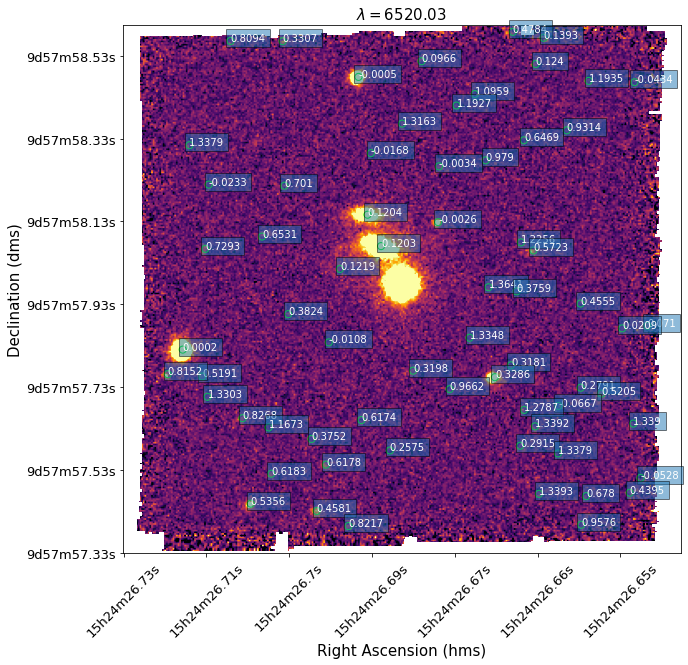

In [38]:
fig, ax = plt.subplots(1, figsize=(10,10))

ax.imshow(spec_arr, vmin = min_flux, vmax = max_flux, cmap='inferno')

ax.scatter(gal_centers_x[z_ids_arr!=-1], gal_centers_y[z_ids_arr!=-1],  facecolors='none', edgecolors='lime', s=50)

for i in range(len(z_ids_arr)):
    if(z_ids_arr[i]!=-1):
        x = gal_centers_x[i]
        y = gal_centers_y[i]
        ax.text(x, y, str(np.round(z_ids_arr[i],5)), color='white', bbox={'alpha':.5})


ax.set_title(r'$\lambda = $' + str(np.round(plot_wav, 2)), fontsize=15)
ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
ax.set_yticklabels(Dec_arr_labels, fontsize=13)

ax.set_xlabel('Right Ascension (hms)', fontsize=15)
ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()

Load in COS FUV redshifts

In [39]:
ids = fits.open(rootdir + 'FUV/PG1522+101_FUV_wavecal_new_identifications.fits')

In [40]:
ids.info()

Filename: /Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/FUV/PG1522+101_FUV_wavecal_new_identifications.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     56   333R x 24C   [10A, L, K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, K, D, K, K]   


In [41]:
ids[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  187 / length of dimension 1                          
NAXIS2  =                  333 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   24 / number of table fields                         
TTYPE1  = 'ion     '                                                            
TFORM1  = '10A     '                                                            
TTYPE2  = 'draw    '                                                            
TFORM2  = 'L       '                                                            
TTYPE3  = 'system_id'       

In [42]:
ids_data = ids[1].data

In [43]:
ids_data = np.array([list(l) for l in ids_data])

In [44]:
n_syst = len(np.unique(ids_data[:,2]))

In [45]:
z_arr_abs = np.zeros(n_syst)

In [46]:
for i in range(1,n_syst+1):
    ids_slice = ids_data[:,2]==str(i)
    z_arr_abs[i-1] = np.mean(np.float_(ids_data[ids_data[:,2]==str(i)][:,4]))

In [47]:
c = 3e+5

In [48]:
valid_gal_ids_arr = gal_ids_arr[z_ids_arr!=-1]
z_arr_gal = z_ids_arr[z_ids_arr!=-1]

In [49]:
vel_grid = np.zeros((len(z_arr_gal), len(z_arr_abs)))

In [50]:
for i in range(len(z_arr_gal)):
    for j in range(len(z_arr_abs)):
        
        vel_grid[i,j] = (z_arr_gal[i]-z_arr_abs[j])*c

In [51]:
columns = [str(i) for i in range(1, n_syst+1)]
rows = [str(i) for i in valid_gal_ids_arr]

In [52]:
df = pd.DataFrame(vel_grid, columns=columns, index=rows)

In [53]:
for i in range(len(z_arr_gal)):
    for j in range(len(z_arr_abs)):
        
        if(np.abs(vel_grid[i,j])<=500):
            print(valid_gal_ids_arr[i], j+1, z_arr_gal[i], z_arr_abs[j], vel_grid[i,j])

1 84 0.5356 0.5358129290810362 -63.878724310861834
5 97 0.8217 0.8218280247279576 -38.40741838727624
18 1 -0.0005 -0.00015904576125617628 -102.28627162314712
19 81 0.4784 0.47836834192276 9.497423171994646
20 24 0.1393 0.139107346534729 57.796039581300974
20 25 0.1393 0.13917434215545654 37.697353363039255
25 110 1.1935 1.1921746730804443 397.5980758667008
25 111 1.1935 1.1923162937164307 355.1118850708024
27 105 1.0959 1.0943943977355957 451.68067932133124
27 106 1.0959 1.0945074558258057 417.76325225832966
27 107 1.0959 1.0945627689361572 401.1693191528609
27 108 1.0959 1.0946276187896729 381.7143630981734
28 110 1.1927 1.1921746730804443 157.59807586672724
28 111 1.1927 1.1923162937164307 115.1118850708288
38 88 0.6469 0.6472345590591431 -100.36771774291076
58 112 1.2256 1.2250397205352783 168.08383941651073
58 113 1.2256 1.2251808643341064 125.74069976807323
58 114 1.2256 1.2252759337425232 97.21987724304881
58 115 1.2256 1.2255995273590088 0.14179229737010246
59 85 0.5723 0.572182